## Import

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [13]:
# data import
df_s = pd.read_csv('df_s_convex.csv')
df_s_true = pd.read_csv('df_s_true_convex.csv')
df_t = pd.read_csv('df_t_convex.csv')
df_t_true = pd.read_csv('df_t_true_convex.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex.csv')
for i in range(4):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_convex.csv')")

In [14]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(4):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    temp_list = [0 for inner_i in range(6)]
    temp_list[i] = 1
    temp_matrix = [temp_list for inner_j in range(len(eval(f"x_t{i}")))]
    temp_matrix = torch.tensor(temp_matrix)
    exec(f"x_t{i} = torch.cat([x_t{i}, temp_matrix], axis=1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
x_t4 = copy.deepcopy(x_s)
temp_list = [0 for inner_i in range(6)]
temp_list[4] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t4))]
temp_matrix = torch.tensor(temp_matrix)
x_t4 = torch.cat([x_t4, temp_matrix], axis=1).type(torch.float32)
y_t4 = copy.deepcopy(y_s)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t))]
temp_matrix = torch.tensor(temp_matrix)
x_t = torch.cat([x_t, temp_matrix], axis=1).type(torch.float32)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t_labeled))]
temp_matrix = torch.tensor(temp_matrix)
x_t_labeled = torch.cat([x_t_labeled, temp_matrix], axis=1).type(torch.float32)

## DARC

In [15]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.fe = nn.Linear(1+(4+1+1), 40)
        self.mid1 = nn.Linear(40,40)
        self.mid2 = nn.Linear(40,40)
        self.mid4 = nn.Linear(40, 1)
        self.relu = nn.ReLU()


    def forward_one(self, x):
        x = self.fe(x)
        x = self.relu(x)
        x = self.mid1(x)
        x = self.relu(x)
        x = self.mid2(x)
        x = self.relu(x)
        x = self.mid4(x)
        x = self.relu(x)
        
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### Meta-Learning

In [16]:
experiment_num = 5
darc_original_vc_result = []
for experiment_i in tqdm(range(experiment_num)):
    model = Siamese()

    # Set the Training Parameters
    lr = 1e-3
    best_model = copy.deepcopy(model)
    best_loss = 10000000

    total_domain_num = 4 + 1 + 1
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    bn = 30*total_domain_num//2

    total_x = x_t_labeled
    total_y = y_t_labeled
    # sample = random.sample(range(len(eval(f"x_t{i}"))), bn)
    for i in range(total_domain_num - 1):
        total_x = torch.cat([total_x, eval(f"x_t{i}")],axis=0)
        total_y = torch.cat([total_y, eval(f"y_t{i}")],axis=0)

    for outer_epoch in range(10000):
        temp_loss = 0
        for inner_epoch in range(5):
            sample1 = random.sample(range(len(total_x)), bn)
            sample2 = random.sample(range(len(total_x)), bn)
            
            xi = total_x[sample1]
            xj = total_x[sample2]
            yi = total_y[sample1]
            yj = total_y[sample2]

            optimizer.zero_grad()
            y_dist = torch.abs(yi - yj)
            z1,z2 = model(xi, xj)
            distance = F.pairwise_distance(z1,z2,keepdim=True)


            psp_loss = torch.abs(y_dist - distance).mean()    
            psp_loss.backward()
            optimizer.step()
            temp_loss += psp_loss
        if outer_epoch % 100 == 99:
            print(f"epoch : {outer_epoch}, train loss : {temp_loss.detach().item()/5}")
        
    MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
    # MLPR = LinearRegression()
    latent_source_x = torch.tensor([])
    latent_source_y = torch.tensor([])
    for i in range(5):
        latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
        latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
    latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
    latent_source_x = np.array(latent_source_x)
    latent_source_y = np.array(latent_source_y)
    latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

    MLPR.fit(latent_source_x, latent_source_y)
    print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

    darc_original_vc_result.append([mean_squared_error(MLPR.predict(latent_target_x), y_t),mean_squared_error(MLPR.predict(latent_target_x), y_t_true)])
    pd.DataFrame(MLPR.predict(latent_source_x), columns=['y_hat']).to_csv(f'DARC_SDE_V_MODEL{experiment_i}.csv', index=0)
    pd.DataFrame(darc_original_vc_result, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('DARC_SDE_V_RESULT.csv', index=0)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 99, train loss : 0.5774913787841797
epoch : 199, train loss : 0.5394044876098633
epoch : 299, train loss : 0.5231765270233154
epoch : 399, train loss : 0.39478087425231934
epoch : 499, train loss : 0.37607693672180176
epoch : 599, train loss : 0.32857046127319334
epoch : 699, train loss : 0.3019432783126831
epoch : 799, train loss : 0.2817178010940552
epoch : 899, train loss : 0.2940572738647461
epoch : 999, train loss : 0.28635368347167967
epoch : 1099, train loss : 0.27362029552459716
epoch : 1199, train loss : 0.25995161533355715
epoch : 1299, train loss : 0.24051785469055176
epoch : 1399, train loss : 0.248543381690979
epoch : 1499, train loss : 0.23024704456329345
epoch : 1599, train loss : 0.2358149290084839
epoch : 1699, train loss : 0.23246026039123535
epoch : 1799, train loss : 0.2352139949798584
epoch : 1899, train loss : 0.1908213496208191
epoch : 1999, train loss : 0.18869975805282593
epoch : 2099, train loss : 0.2054594039916992
epoch : 2199, train loss : 0.1608206

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 1/5 [02:55<11:41, 175.27s/it]

epoch : 9999, train loss : 0.14140427112579346
test mse : 0.055738769471645355, denoised test mse : 0.044435810297727585
epoch : 99, train loss : 0.5816643238067627
epoch : 199, train loss : 0.49295220375061033
epoch : 299, train loss : 0.489909029006958
epoch : 399, train loss : 0.4683074951171875
epoch : 499, train loss : 0.38799538612365725
epoch : 599, train loss : 0.2848616600036621
epoch : 699, train loss : 0.30719265937805174
epoch : 799, train loss : 0.2781223773956299
epoch : 899, train loss : 0.24787464141845703
epoch : 999, train loss : 0.26414263248443604
epoch : 1099, train loss : 0.26459636688232424
epoch : 1199, train loss : 0.23930768966674804
epoch : 1299, train loss : 0.22337148189544678
epoch : 1399, train loss : 0.22482030391693114
epoch : 1499, train loss : 0.20109455585479735
epoch : 1599, train loss : 0.18121368885040284
epoch : 1699, train loss : 0.19213706254959106
epoch : 1799, train loss : 0.17500708103179932
epoch : 1899, train loss : 0.17428492307662963
epo

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 2/5 [05:53<08:51, 177.23s/it]

epoch : 99, train loss : 0.5440267086029053
epoch : 199, train loss : 0.52852463722229
epoch : 299, train loss : 0.431975793838501
epoch : 399, train loss : 0.43399906158447266
epoch : 499, train loss : 0.36343111991882326
epoch : 599, train loss : 0.3260119199752808
epoch : 699, train loss : 0.3335599422454834
epoch : 799, train loss : 0.31685285568237304
epoch : 899, train loss : 0.3059354782104492
epoch : 999, train loss : 0.2806967496871948
epoch : 1099, train loss : 0.28541557788848876
epoch : 1199, train loss : 0.2344149112701416
epoch : 1299, train loss : 0.27640910148620607
epoch : 1399, train loss : 0.2786672592163086
epoch : 1499, train loss : 0.23472402095794678
epoch : 1599, train loss : 0.24203147888183593
epoch : 1699, train loss : 0.2386319637298584
epoch : 1799, train loss : 0.20752882957458496
epoch : 1899, train loss : 0.1973087430000305
epoch : 1999, train loss : 0.18059492111206055
epoch : 2099, train loss : 0.18851144313812257
epoch : 2199, train loss : 0.158555126

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60%|██████    | 3/5 [08:48<05:52, 176.09s/it]

epoch : 9999, train loss : 0.14899396896362305
test mse : 0.08273725211620331, denoised test mse : 0.072974793612957
epoch : 99, train loss : 0.5554884910583496
epoch : 199, train loss : 0.48012609481811525
epoch : 299, train loss : 0.44681501388549805
epoch : 399, train loss : 0.4045990467071533
epoch : 499, train loss : 0.4155909538269043
epoch : 599, train loss : 0.3923746347427368
epoch : 699, train loss : 0.3708971977233887
epoch : 799, train loss : 0.39295158386230467
epoch : 899, train loss : 0.3866448402404785
epoch : 999, train loss : 0.3778665781021118
epoch : 1099, train loss : 0.38722589015960696
epoch : 1199, train loss : 0.3863616228103638
epoch : 1299, train loss : 0.3336228847503662
epoch : 1399, train loss : 0.3750462532043457
epoch : 1499, train loss : 0.2851932287216187
epoch : 1599, train loss : 0.3583832263946533
epoch : 1699, train loss : 0.3437699317932129
epoch : 1799, train loss : 0.3772190809249878
epoch : 1899, train loss : 0.3482470989227295
epoch : 1999, tr

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 80%|████████  | 4/5 [11:24<02:48, 168.11s/it]

epoch : 9999, train loss : 0.2614036321640015
test mse : 0.07399491220712662, denoised test mse : 0.06397653371095657
epoch : 99, train loss : 0.5963437557220459
epoch : 199, train loss : 0.5322035789489746
epoch : 299, train loss : 0.4372409820556641
epoch : 399, train loss : 0.41521391868591306
epoch : 499, train loss : 0.42847189903259275
epoch : 599, train loss : 0.3867460012435913
epoch : 699, train loss : 0.3958653688430786
epoch : 799, train loss : 0.3953830718994141
epoch : 899, train loss : 0.36568236351013184
epoch : 999, train loss : 0.36794395446777345
epoch : 1099, train loss : 0.39829330444335936
epoch : 1199, train loss : 0.3253933429718018
epoch : 1299, train loss : 0.3345343589782715
epoch : 1399, train loss : 0.3652277946472168
epoch : 1499, train loss : 0.3243728160858154
epoch : 1599, train loss : 0.3067368984222412
epoch : 1699, train loss : 0.33022873401641845
epoch : 1799, train loss : 0.28132855892181396
epoch : 1899, train loss : 0.29630541801452637
epoch : 199

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 5/5 [13:17<00:00, 159.53s/it]

epoch : 9999, train loss : 0.28436233997344973
test mse : 0.0886133685708046, denoised test mse : 0.07899023592472076


### Meta-Inference

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test mse : 0.09132684767246246, denoised test mse : 0.08191759139299393


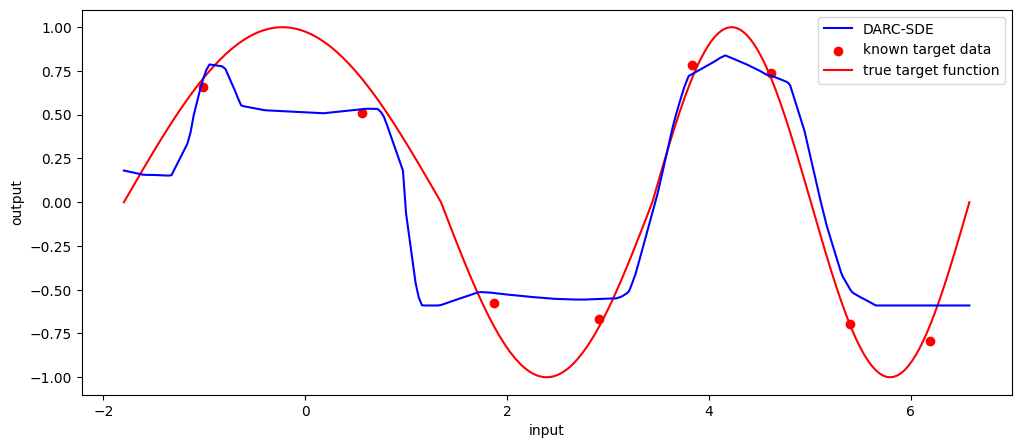

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
# MLPR = LinearRegression()
latent_source_x = torch.tensor([])
latent_source_y = torch.tensor([])
for i in range(5):
    latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
latent_source_x = np.array(latent_source_x)
latent_source_y = np.array(latent_source_y)
latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

MLPR.fit(latent_source_x, latent_source_y)
print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

plt.figure(figsize=(12,5))
plt.plot(x_t[:,[0]], MLPR.predict(latent_target_x), c='blue', label='DARC-SDE', zorder=2)
plt.scatter(x_t_labeled[:,[0]], y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t[:,[0]], y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
